In [1]:
import logging
import numpy as np
from math import sin, cos, pi
from ionqvision.modules import BinaryMNISTClassifier
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from AngleEncoderRots import AngleEncoderX,AngleEncoderY, AngleEncoderZ
from trotter import ButterflyOrthogonalAnsatz

In [2]:
NUM_QUBITS = 4 # constant, number of qubits used in circuit

In [3]:
## Set up the butterfly orthogonal ansatz with an interweaving suzuki-trotter circuit

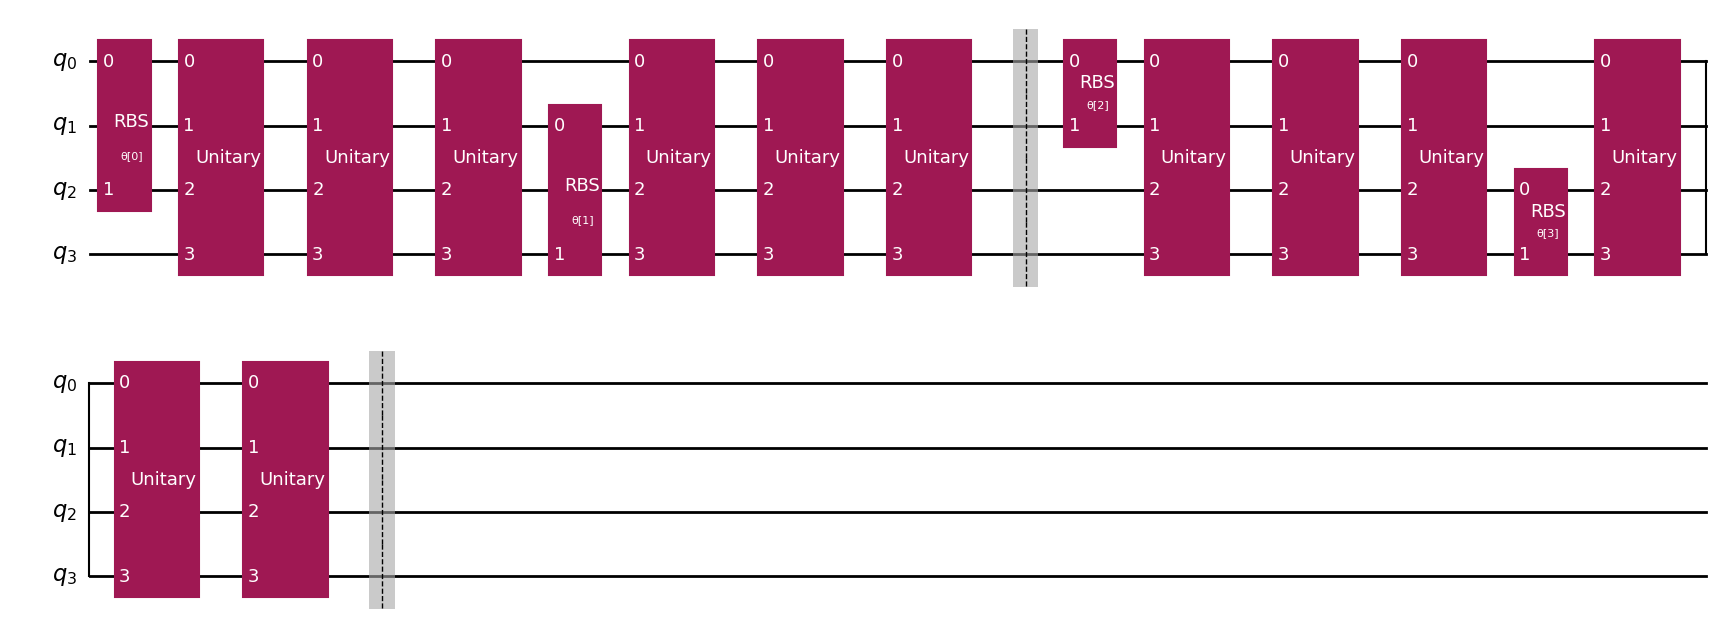

In [4]:
ansatz = ButterflyOrthogonalAnsatz(num_qubits=NUM_QUBITS)
ansatz.draw('mpl')

In [5]:
## Set up Angle Encoder with a Y bias

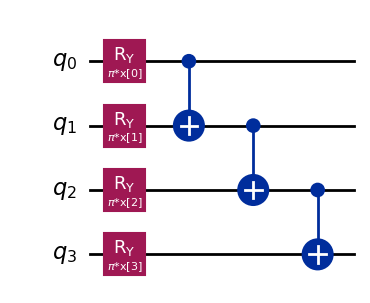

In [6]:
encoder = AngleEncoderY(num_qubits=NUM_QUBITS)
encoder.draw("mpl")

In [7]:
## Set up Pauli Operators to be able to observe the output

In [8]:
SPO_base = "I" * (NUM_QUBITS - 1)

quantum_features = [
    SparsePauliOp([SPO_base + "X"]), 
    SparsePauliOp([SPO_base + "Y"]), 
    SparsePauliOp([SPO_base + "Z"])
]

In [9]:
## Create the classifier based on the MNIST database

In [10]:
classifier = BinaryMNISTClassifier(encoder, ansatz, quantum_features); classifier

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01025 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01025 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01001 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 6.87194 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('qsd2q', 2), ('ry', 1), ('cz', 2), ('cx', 2), ('rz', 1)} to target basis {'cx', 'snapshot', 'u', 'barrier', 'while_loop', 'measure', 'for_loop', 'if_else', 'qsd2q', 'delay', 'reset', 'store', 'switch_case'}.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.001s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.003s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.001s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 6.79946 (ms)
INFO:qiskit.passmana

BinaryMNISTClassifier(
  (latent_vec_encoder): Sequential(
    (0): Linear(in_features=168, out_features=4, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
  (quantum_layer): QuantumModule()
  (prediction_head): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Sigmoid()
  )
)

In [11]:
## View the quantum layer!

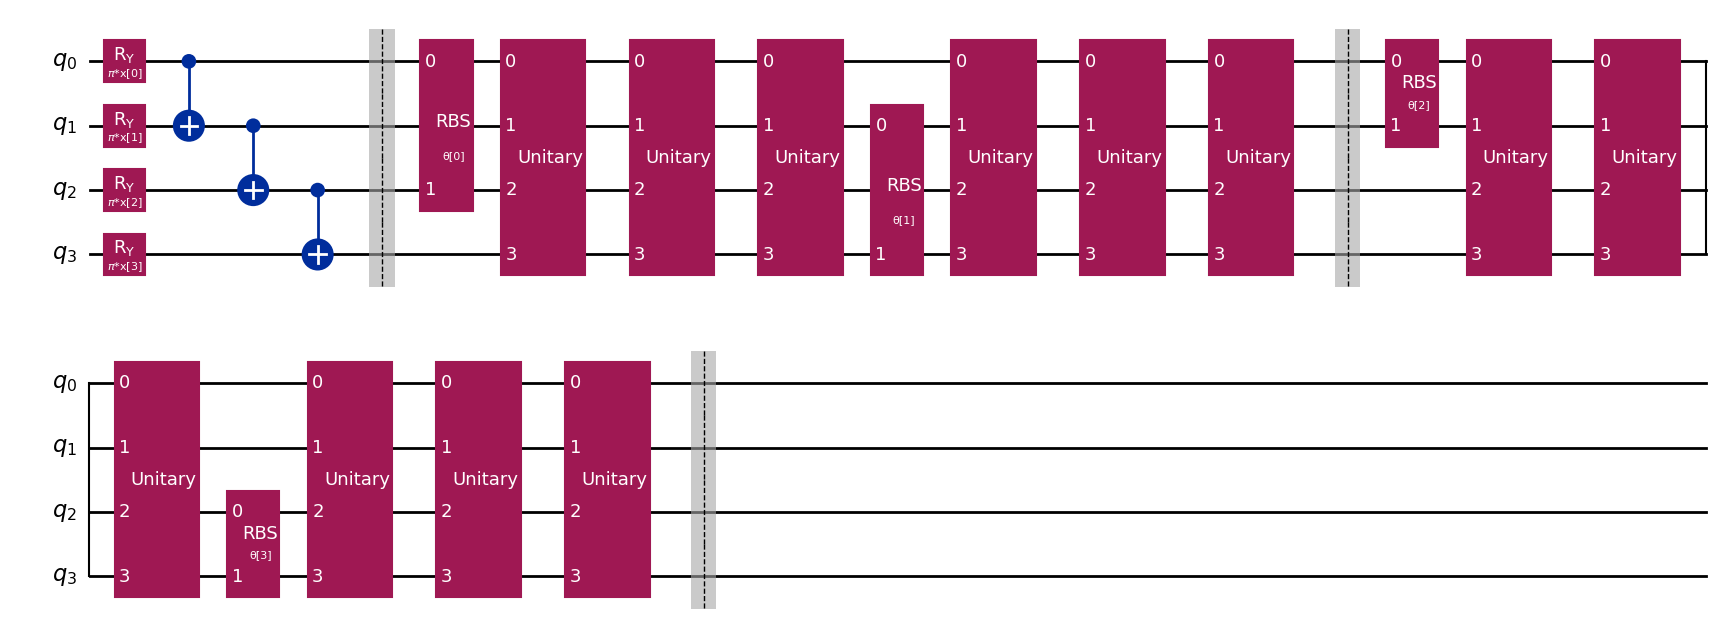

In [12]:
classifier.quantum_layer.layer_qc.draw("mpl")

In [13]:
## Train and test the quantum layer!

In [ ]:
%%time
# Get a (pre-processed) training and test set
train_set, test_set = classifier.get_train_test_set(train_size=300, test_size=100)

# Configure model training hyper parameters
config = {
    "epochs": 2,
    "lr": 0.05, # If the model’s loss oscillates or fails to converge, reduce the learning rate.
    "batch_size": 19, # Smaller batch sizes tend to allow for more frequent updates but introduce more variance
    "betas": (0.9, 0.99),
    "weight_decay": 1e-3,
    "clip_grad": True,
    "log_interval": 6,
}

# Train and plot the results
classifier.train_module(train_set, test_set, config) #let's save until we get the new S-T
classifier.plot_training_progress()

In [ ]:
from qbraid.runtime import QbraidSession
from ionqvision.scq_client import IonQSCQClient

session = QbraidSession()

client = IonQSCQClient(session=session)

submission_data = classifier.submit_model_for_grading(client=client)

message = submission_data.get("message")
submission_id = submission_data.get("submissionId")

print(message)

client.await_autograder_result(submission_id=submission_id)